# Smile Recognition Using scikit-learn

Used tutorial: https://flothesof.github.io/smile-recognition.html

We will use an existing dataset,
called the "Olivetti faces dataset" and classify the $400$ faces seen there in one of two categories:
smiling or not smiling.
Then, we train a support vector classifier on this dataset to predict if a face depicts a smiling person or not.
We do this by using the `sklearn` machine learning library for Python.

In [1]:
%matplotlib inline
from pylab import *

import json

from ipywidgets import interact, Button, HBox, VBox
from IPython.display import display, clear_output

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from scipy.stats import sem
from sklearn import metrics

## Training a classifier on the existing faces dataset

### Loading the faces dataset

We load the dataset using standard `sklearn` function below.

In [2]:
faces = datasets.fetch_olivetti_faces()

The `faces` dataset consist of $400$ images depicting $40$ subjects in a variety of poses: open and closed eyes,
smiling or not.
The data can be accessed trough the keys below:

In [3]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

One can plot a selection of images from the dataset.

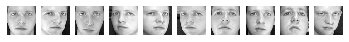

In [4]:
for i in range(10):
    face = faces.images[i]
    subplot(1, 10, i + 1)
    imshow(face.reshape((64, 64)), cmap="gray")
    axis("off")

### Producing the smile training data

Now that the dataset is loaded,
we will build a cheap user interface to classify the $400$ images into two categories:
- smiling face
- not smiling face

The class below stores the outcome of the user classification as a dictionary and is used to display the next
image upon pressing a button from the GUI.

In [5]:
class Trainer:
    def __init__(self):
        self.results = {}
        self.images = faces.images
        self.index = 0
    
    def increment_face(self):
        if self.index + 1 >= len(self.images):
            return self.index
        else:
            self.index += 1
            return self.index
    
    def record_result(self, smile=True):
        self.results[str(self.index)] = smile

We first instantiate the class and then design a user interface using two buttons from the `ipywidgets` tools.

In [6]:
trainer = Trainer()

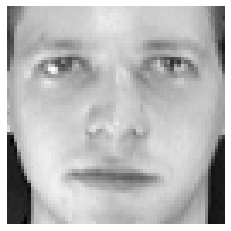

In [7]:
button_smile = Button(description="smile")
button_no_smile = Button(description="no smile")

def display_face(face):
    clear_output()
    imshow(face, cmap="gray")
    axis("off")
    
def update_smile(b):
    trainer.record_result(smile=True)
    trainer.increment_face()
    display_face(trainer.images[trainer.index])
    button_smile.on_click(update_smile)
    display(HBox((button_smile, button_no_smile)))
    
def update_no_smile(b):
    trainer.record_result(smile=False)
    trainer.increment_face()
    display_face(trainer.images[trainer.index])
    button_no_smile.on_click(update_no_smile)
    display(HBox((button_smile, button_no_smile)))

button_smile.on_click(update_smile)
button_no_smile.on_click(update_no_smile)

display_face(trainer.images[trainer.index])
display(HBox((button_smile, button_no_smile)))

### Saving and loading the temporary results from the classification

#### Loading training dataset

In [8]:
results = json.load(open('results.xml'))
trainer.results = results

#### Saving training dataset

In [9]:
with open('results.xml', 'w') as f:
    json.dump(trainer.results, f)

## Visualizing the training set data

Now that our input data is ready, we can plot a little statistic from our dataset:
how many people are smiling in the pictures and how many are not.

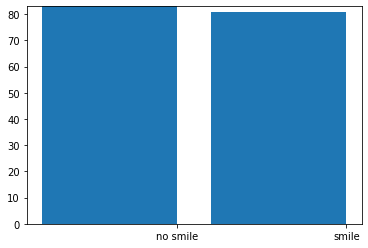

In [10]:
yes, no = (sum([trainer.results[x] == True for x in trainer.results]), 
            sum([trainer.results[x] == False for x in trainer.results]))
bar([0, 1], [no, yes])
ylim(0, max(yes, no))
xticks([0.4, 1.4], ['no smile', 'smile']);

Below, we're displaying the images of all the smiles and all the "non smiles" that we have classified.

In [11]:
smiling_indices = [int(i) for i in trainer.results if trainer.results[i] == True]

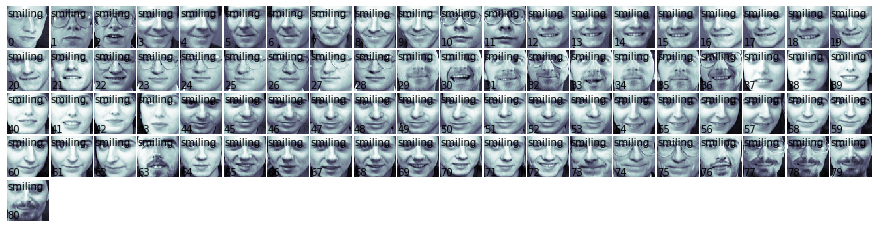

In [12]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[smiling_indices[i]], cmap=plt.cm.bone)
    
    # label the image with the target value
    p.text(0, 14, "smiling")
    p.text(0, 60, str(i))
    p.axis('off')

As you can see, some of the faces classified as smiling could be disagreed with.
In fact, I often found myself confused while doing this task,
because some of the images cannot be easily put into a smiling or non-smiling category in my opinion.

In [13]:
not_smiling_indices = [int(i) for i in trainer.results if trainer.results[i] == False]

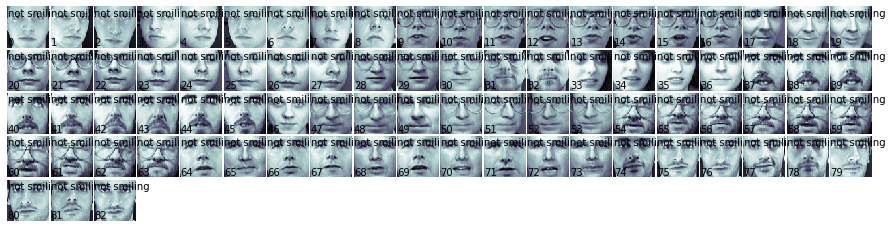

In [14]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(not_smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[not_smiling_indices[i]], cmap=plt.cm.bone)

    # label the image with the target value
    p.text(0, 14, "not smiling")
    p.text(0, 60, str(i))
    p.axis('off')

## Training the smile classifier

Now that we have our input data, we can train a machine learning model with it.

We use a support vector classifier to learn from the $400$
smiles and non-smiles and predict the classification of a new image.

First, we initialize the classifier with:

In [15]:
svc = SVC(kernel='linear')

We then build our dataset.
First comes the image data:

In [16]:
indices = [i for i in trainer.results]
indices = [int(index) for index in indices]
data = faces.data[indices]

Then comes the target vector (in which a $1$ stands for a smile and a $0$ for a "non smile").

In [17]:
target = [trainer.results[i] for i in trainer.results]
target = array(target).astype(int32)

Finally, we train the classifier using $5$ fold cross validation.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=0.25, random_state=0)

In [19]:
def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(n_splits=K)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

The trained classifier's performance is then evaluated:

In [20]:
evaluate_cross_validation(svc, X_train, y_train, 5)

[0.8        0.68       0.68       0.79166667 0.75      ]
Mean score: 0.740 (+/-0.026)


A mean score of approximately $0.7$ is quite good.
A further statistic is the confusion matrix that shows the errors that the classifier made during training.

In [21]:
def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Classification Report:")
    print (metrics.classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))

In [22]:
train_and_evaluate(svc, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.8536585365853658
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       0.88      0.79      0.83        19

    accuracy                           0.85        41
   macro avg       0.86      0.85      0.85        41
weighted avg       0.86      0.85      0.85        41

Confusion Matrix:
[[20  2]
 [ 4 15]]


## Testing the classifier on the training data

To check that our the trained machine learning classifier works,
we again build a "cheap" GUI for displaying a face as well as the classifier prediction for this face

this person is smiling: [False]


Button(description='New image!', style=ButtonStyle())

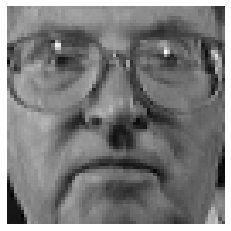

In [23]:
random_image_button = Button(description="New image!")

def display_face_and_prediction(b):
    index = randint(0, 400)
    print(index)
    face = faces.images[index]
    display_face(face)
    print("this person is smiling: {0}".format(svc.predict(faces.data[index].reshape(1, -1))==1))
    display(random_image_button)

random_image_button.on_click(display_face_and_prediction)
display(random_image_button)
display_face_and_prediction(0)